In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

tensorflow.keras: To build and train the LSTM model

numpy, pandas: For numerical and tabular data handling

matplotlib: To visualize loss and predictions

MinMaxScaler: To normalize the data for better LSTM performance

We used LSTM because it can effectively learn from historical price data and capture time-based patterns, making it ideal for predicting Bitcoin price trends.

In [ ]:
from google.colab import drive
drivepath = "/content/drive"
drive.mount(drivepath, force_remount=True)
filepath= "/BTC-USD (1).csv"
df= pd.read_csv(filepath)
print(df)

Mounted at /content/drive
            Date          Open          High           Low         Close  \
0     2014-09-17    465.864014    468.174011    452.421997    457.334015   
1     2014-09-18    456.859985    456.859985    413.104004    424.440002   
2     2014-09-19    424.102997    427.834991    384.532013    394.795990   
3     2014-09-20    394.673004    423.295990    389.882996    408.903992   
4     2014-09-21    408.084991    412.425995    393.181000    398.821014   
...          ...           ...           ...           ...           ...   
2396  2021-04-09  58326.562500  58937.046875  57807.863281  58245.003906   
2397  2021-04-10  58253.777344  61276.664063  58038.707031  59793.234375   
2398  2021-04-11  59846.230469  60790.554688  59289.796875  60204.964844   
2399  2021-04-12  60175.945313  61253.035156  59589.875000  59893.453125   
2400  2021-04-13  60292.875000  63152.812500  59892.859375  62944.847656   

         Adj Close        Volume  
0       457.334015  2.1056

In [ ]:
df = df.dropna()
print(df)

            Date          Open          High           Low         Close  \
0     2014-09-17    465.864014    468.174011    452.421997    457.334015   
1     2014-09-18    456.859985    456.859985    413.104004    424.440002   
2     2014-09-19    424.102997    427.834991    384.532013    394.795990   
3     2014-09-20    394.673004    423.295990    389.882996    408.903992   
4     2014-09-21    408.084991    412.425995    393.181000    398.821014   
...          ...           ...           ...           ...           ...   
2396  2021-04-09  58326.562500  58937.046875  57807.863281  58245.003906   
2397  2021-04-10  58253.777344  61276.664063  58038.707031  59793.234375   
2398  2021-04-11  59846.230469  60790.554688  59289.796875  60204.964844   
2399  2021-04-12  60175.945313  61253.035156  59589.875000  59893.453125   
2400  2021-04-13  60292.875000  63152.812500  59892.859375  62944.847656   

         Adj Close        Volume  
0       457.334015  2.105680e+07  
1       424.44000

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

We read the dataset from CSV

Removed missing values to avoid errors during training

Converted the date column to datetime type for sorting

Sorted data chronologically because time series models need sequential input

In [ ]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

scaled_df = pd.DataFrame(scaled_data, columns=features)
scaled_df['Date'] = df['Date'].values

LSTMs are sensitive to the scale of input values

Normalizing between 0 and 1 speeds up learning and improves performance

In [ ]:
sequence_length = 60

X = []
y = []

data = scaled_df[features].values

for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i][3])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2337, 60, 5)
y shape: (2337,)


LSTM takes a sequence of previous values as input

We used the past 60 days to predict the next day's Close price

X: past 60 days of prices (Open, High, Low, Close, Volume)

y: next day’s Close price

In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

To evaluate model performance, we use 80% for training and 20% for testing

This helps check if the model generalizes well to unseen data

In [ ]:
model = models.Sequential()
model.add(layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.LSTM(50))
model.add(layers.Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We use 2 LSTM layers to extract temporal patterns

return_sequences=True is used in the first LSTM so it passes a sequence to the next LSTM layer

Final Dense(1) outputs a single value (predicted Close price)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

Adam is a powerful optimizer for time series

mean_squared_error is used because we're solving a regression problem (predicting a number)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 1.1812e-04 - val_loss: 0.0055
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 9.5557e-05 - val_loss: 0.0082
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 8.5414e-05 - val_loss: 0.0079
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 1.0718e-04 - val_loss: 0.0082
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 6.6695e-05 - val_loss: 0.0077
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 5.2752e-05 - val_loss: 0.0073
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 7.0751e-05 - val_loss: 0.0068
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 6.4889e-05 - val_loss: 0.0039
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 5.9413e-05 - val_loss: 0.0067
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 5.5188e-05 - val_loss: 0.0056
Epoch 12/50
59/59 ━━━━

We train the model for 50 epochs for a better accuracy

validation_data helps us see how the model performs on unseen data while training

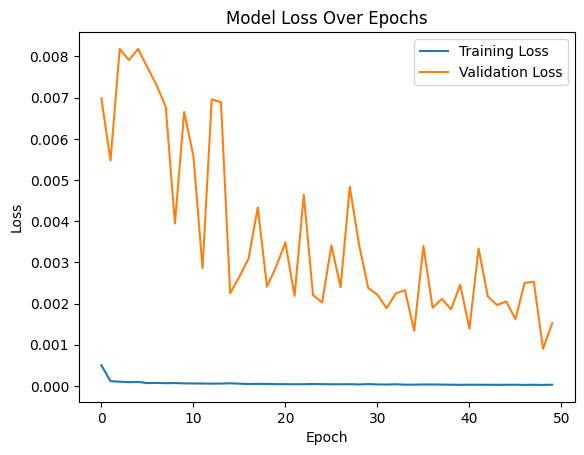

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Helps you visualize overfitting or underfitting

If validation loss is much higher than training loss, the model might be overfitting

Overfitting: The model performs well on training data but poorly on validation data due to learning noise and details instead of general patterns.

Underfitting: The model is too simple to capture the underlying patterns, resulting in poor performance on both training and validation data.

In [ ]:
test_loss = model.evaluate(X_test, y_test, verbose=2)
print("Test Loss:", test_loss)

15/15 - 0s - 19ms/step - loss: 0.0015
Test Loss: 0.0015222860965877771


Quantifies how well the model performs on unseen test data

In [ ]:
predicted_scaled = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


We predict normalized values first (because the model was trained on scaled data)

In [ ]:
predicted_full = np.zeros((predicted_scaled.shape[0], len(features)))
true_full = np.zeros((y_test.shape[0], len(features)))


predicted_full[:, 3] = predicted_scaled[:, 0]
true_full[:, 3] = y_test


predicted_prices = scaler.inverse_transform(predicted_full)[:, 3]
actual_prices = scaler.inverse_transform(true_full)[:, 3]

To convert the scaled predicted Close values back to real USD prices

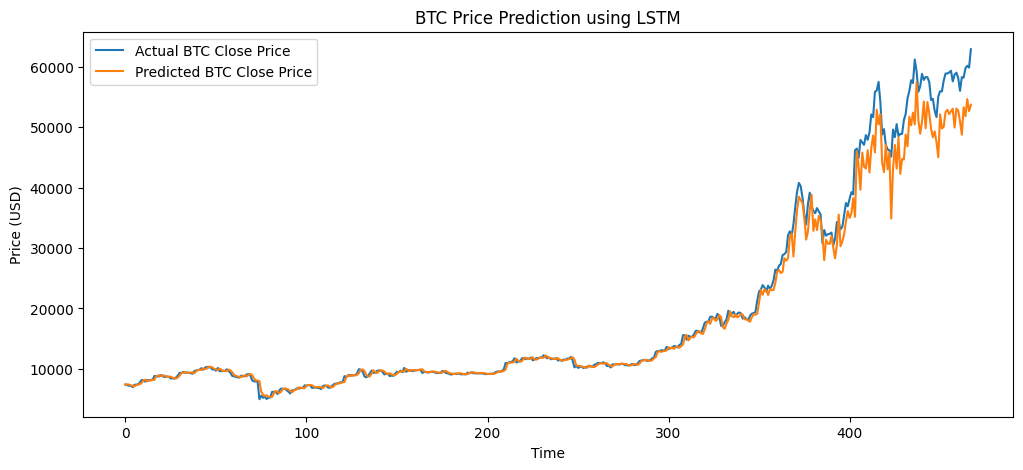

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label="Actual BTC Close Price")
plt.plot(predicted_prices, label="Predicted BTC Close Price")
plt.title("BTC Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

This visual proof shows how close the model's predictions are to reality

The closer the lines, the better your model is